# Lesson: Distributions

## Breaking down our (lego) model

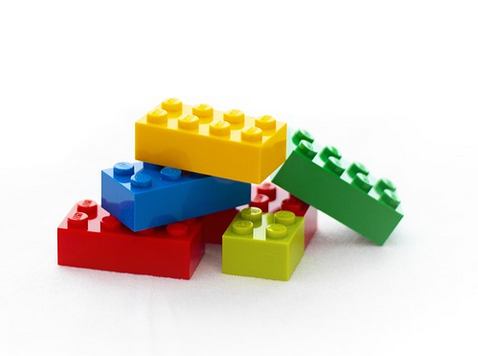

In this lesson we're going to break down our model and study the smallest piece, that is distributions. After all that is what Bayesian models are made of. 

We'll cover why distributions are fantastic building blocks, how to define these building blocks, and some of the amazing properties of them that are central to all the modeling benefits that you've seen in this course, and will see when using Bayes in the real world.

### Distributions and Uncertainty

* How distributions formalize uncertainty
* Why we'll focus on computational specification
* How distributions are central to Bayes Theorem

### Distribution Parameters
* What distribution parameters are
* How they define the shape of a distribution
* That there are differing naming conventions

### Two Types of Samples
* The two types of samples that enable modern Bayesian inference 
  * Observed samples of your data
  * Samples from computational distributions
* What each does to enable inference

### PMF and PDF
* How to compare relative beliefs using Probability Density and Probability Mass functions
* How to calculate PDF and PMF
* Why this is important in a Bayesian context

# The expressiveness of Distributions 

Why distributions are a fundamental tool in summarizing observations, parameters, and uncertainty

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy
from scipy import stats

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [4]:
az.style.use("arviz-darkgrid")
RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)

# Revisiting our A/B test

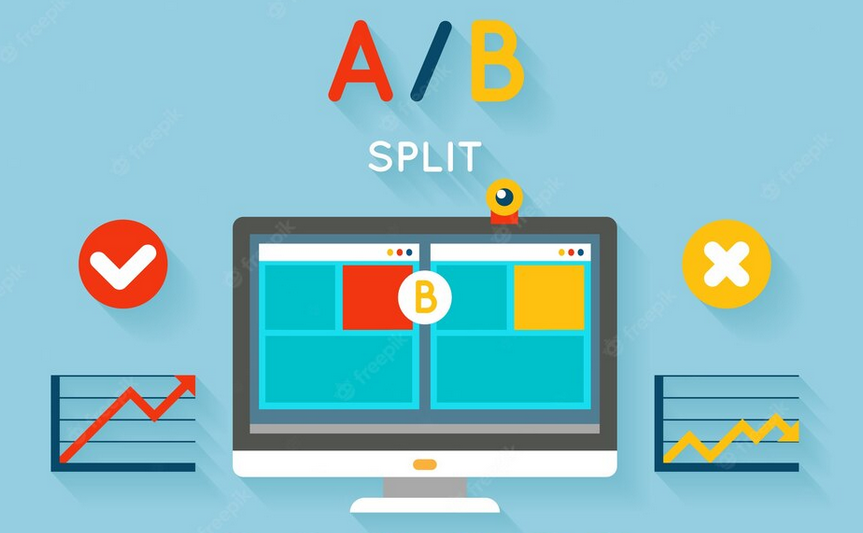

<a href="https://www.freepik.com/vectors/people">People vector created by macrovector - www.freepik.com</a>

We've now seen our A/B test model a couple of times. Let's dive into the details and talk about each individual piece of it. 

Let's start by loading the data.

In [5]:
# If reading this outside of the video I'm saving the data locally as we don't cover 
# sampling until a later section!
np.random.seed(RANDOM_SEED)
b = stats.bernoulli(p=.15)
b_observations = b.rvs(100)
np.savetxt("b_observations.txt", b_observations)

In [6]:
#TODO; Update to match tools lessons
b_observations = np.loadtxt("b_observations.txt")
b_observations 

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [7]:
b_observations.shape

(100,)

Great we have our data loaded in memory and we're already starting to get a sense of things. We can see more 0's than one's but we want to be exact.

An array is all well and good but it's hard to make sense of a 100 length array
but at least we can see all the numbers on screen.

Now imagine if we instead had 1000, or 10000 observations. Staring at an array won't be feasible

## Observed distribution

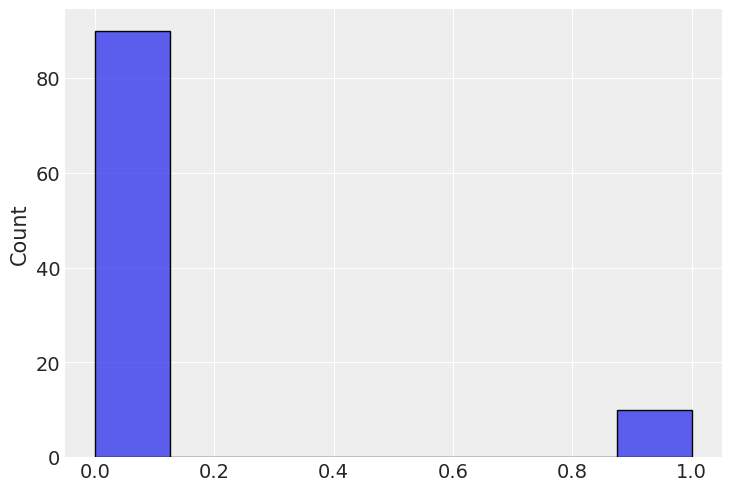

In [5]:
sns.histplot(b_observations);

We can use distributions to summarize the results. In this case we have plotted the *observed* distribution 

## Observed distribution numericall


In [6]:
pd.DataFrame(b_observations).value_counts()

0.0    90
1.0    10
dtype: int64

This is great because it clearly shows the number conversions, and non conversions.
We could choose to summarize the information numerically as well

## Probability Distribution
Observational distributions are great, it answers our questions of *How many converted in 100?* 

But what if we instead ask _"What is the probability a single person will convert?"_

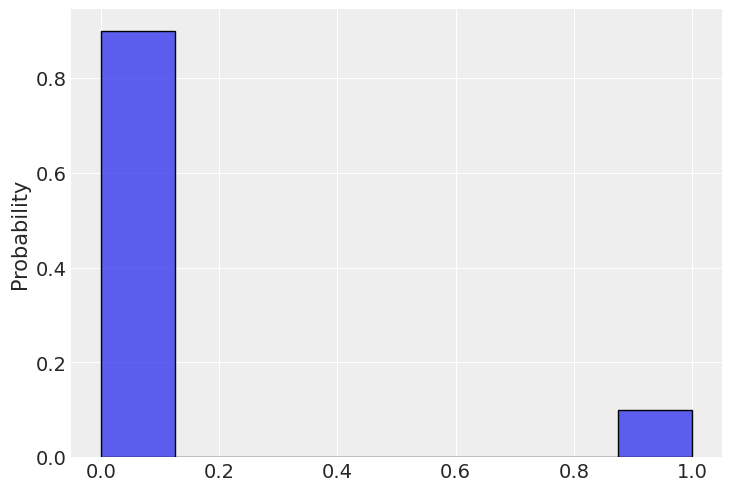

In [7]:
sns.histplot(b_observations, stat="probability");

Simple! We can plot our *empirical* estimate of the probability by just adding one 
keyword argument. 

Compare this against our previous figure and note the y axis has been changed from count to observed probability
We took our counts of conversions and non conversions and divided by the total count, shown below.

In [8]:
obs = pd.DataFrame(b_observations)
obs.value_counts() / obs.shape[0]

0.0    0.9
1.0    0.1
dtype: float64

This allows us to meet the fundamental rule of probability distributions, that the total area must sum to 1.

## Parameter Space and Observation Space as distinct spaces

Note: Add a picture there

There is both an *observed* space and a *parameter space*.

In our example the count of conversions is in observed space because we can "see it", whereas the probability of conversion is a parameter we are estimating.

## How sure are about our parameter estimate, `p(conversion)`?
**Observation**: From 100 people we saw 10% convert, 

**Question**: How sure are we 10% is the *true* conversion rate?

**Thought Experiment**: What if we ran an experiment with _just_ 10 people? 



Let's use our same array. We'll also use the mean function which will give us the probability of a conversion, same as we did before but with less code

In [9]:
b_observations[:10].mean()

0.2

Well this is weird, with 100 observations we got 10%, but now we have 20%? Which number is correct?

## What if we just had one observation, what would `p(conversion)` be?
Let's take this to the extreme. What if we just had one observation?

In [10]:
b_observations[0].mean()

0.0

0% conversion? Was our experiment a total failure?

But with only one observation do we really feel certain about our estimate of p?

## Uncertainty in `p(conversion)`

TODO: Add something visually interesting here



The truth is we might never know the exact conversion ratio, but we do know that a single number doesn't adequately communicate our confidence in our belief in P.

Using a single number point estimate like 10%, 20%, or 0% doesn't convey *uncertainty*

## Communicating uncertainty with distributions


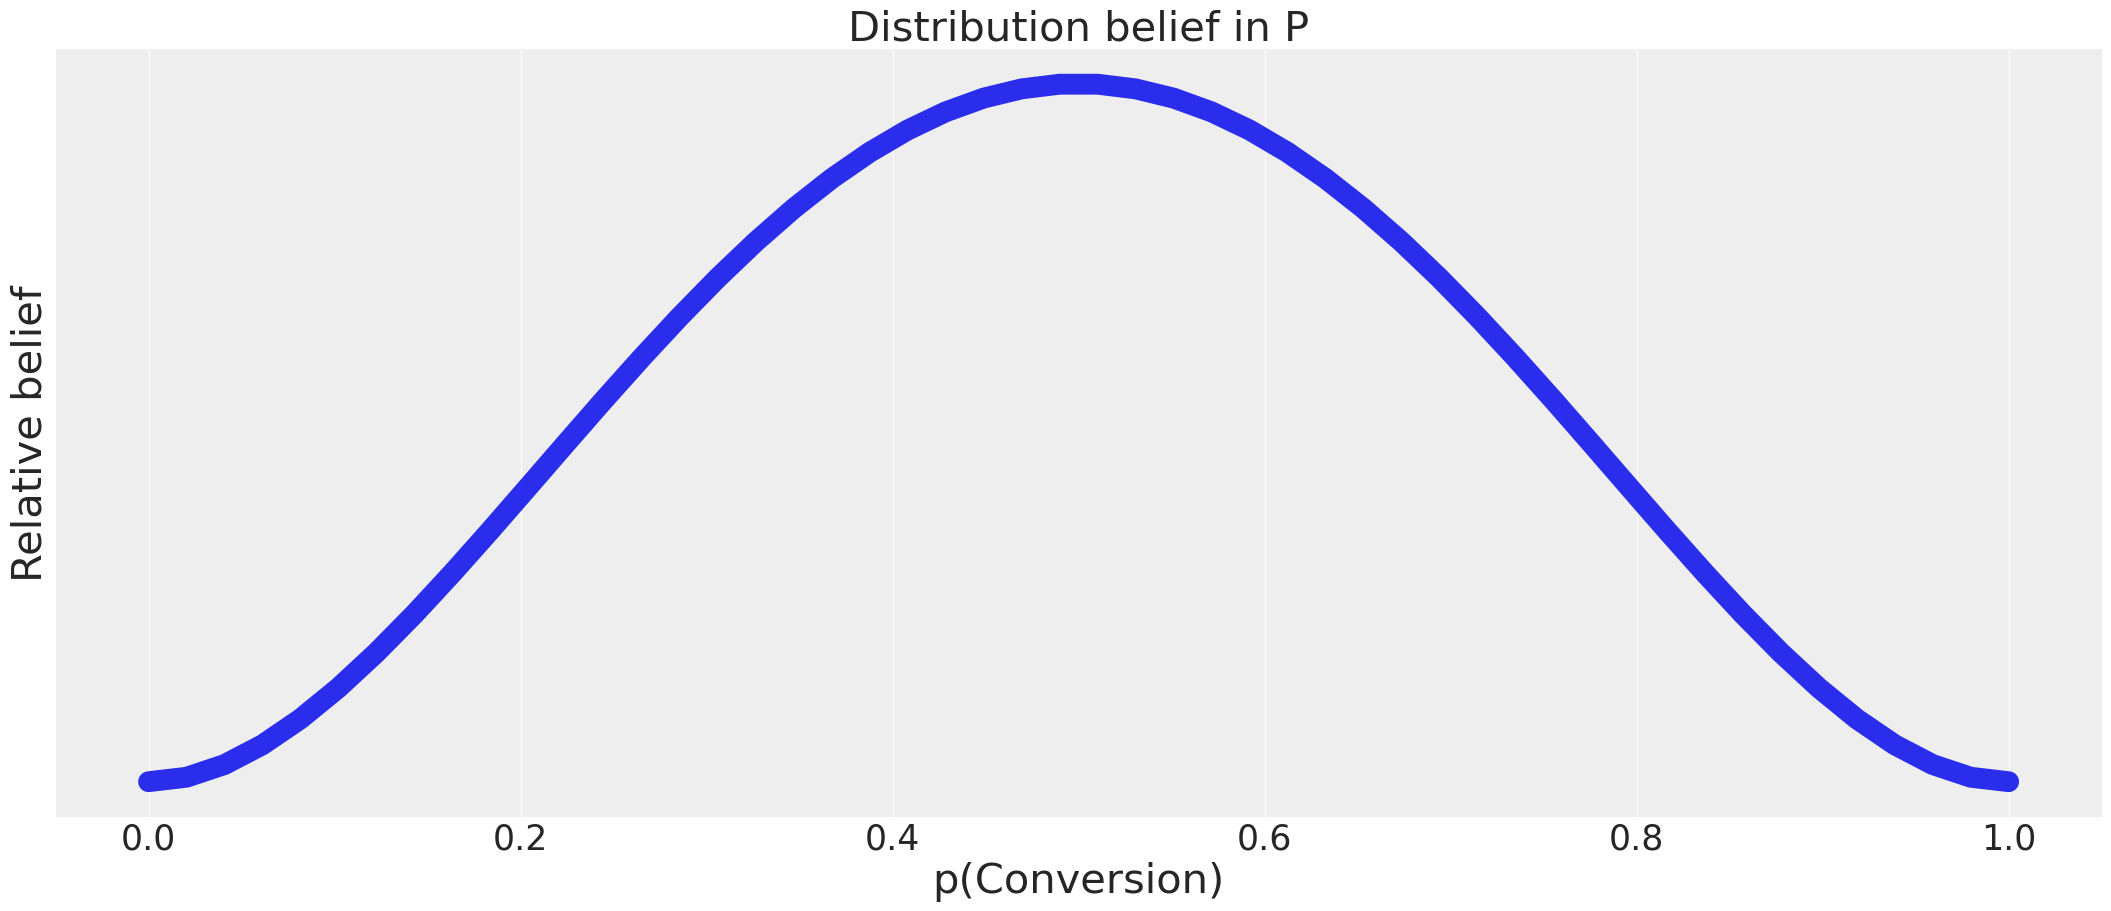

In [11]:
beta_dist = stats.beta(3, 3)
x = np.linspace(0, 1)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)


To communicate uncertainty we a distribution. 

The distribution below shows one possible belief set for p values. 

The x axis is every possible value of the *probability of conversion* and the blue line is our relative belief in each value.

## A possible belief distribution for  conversion


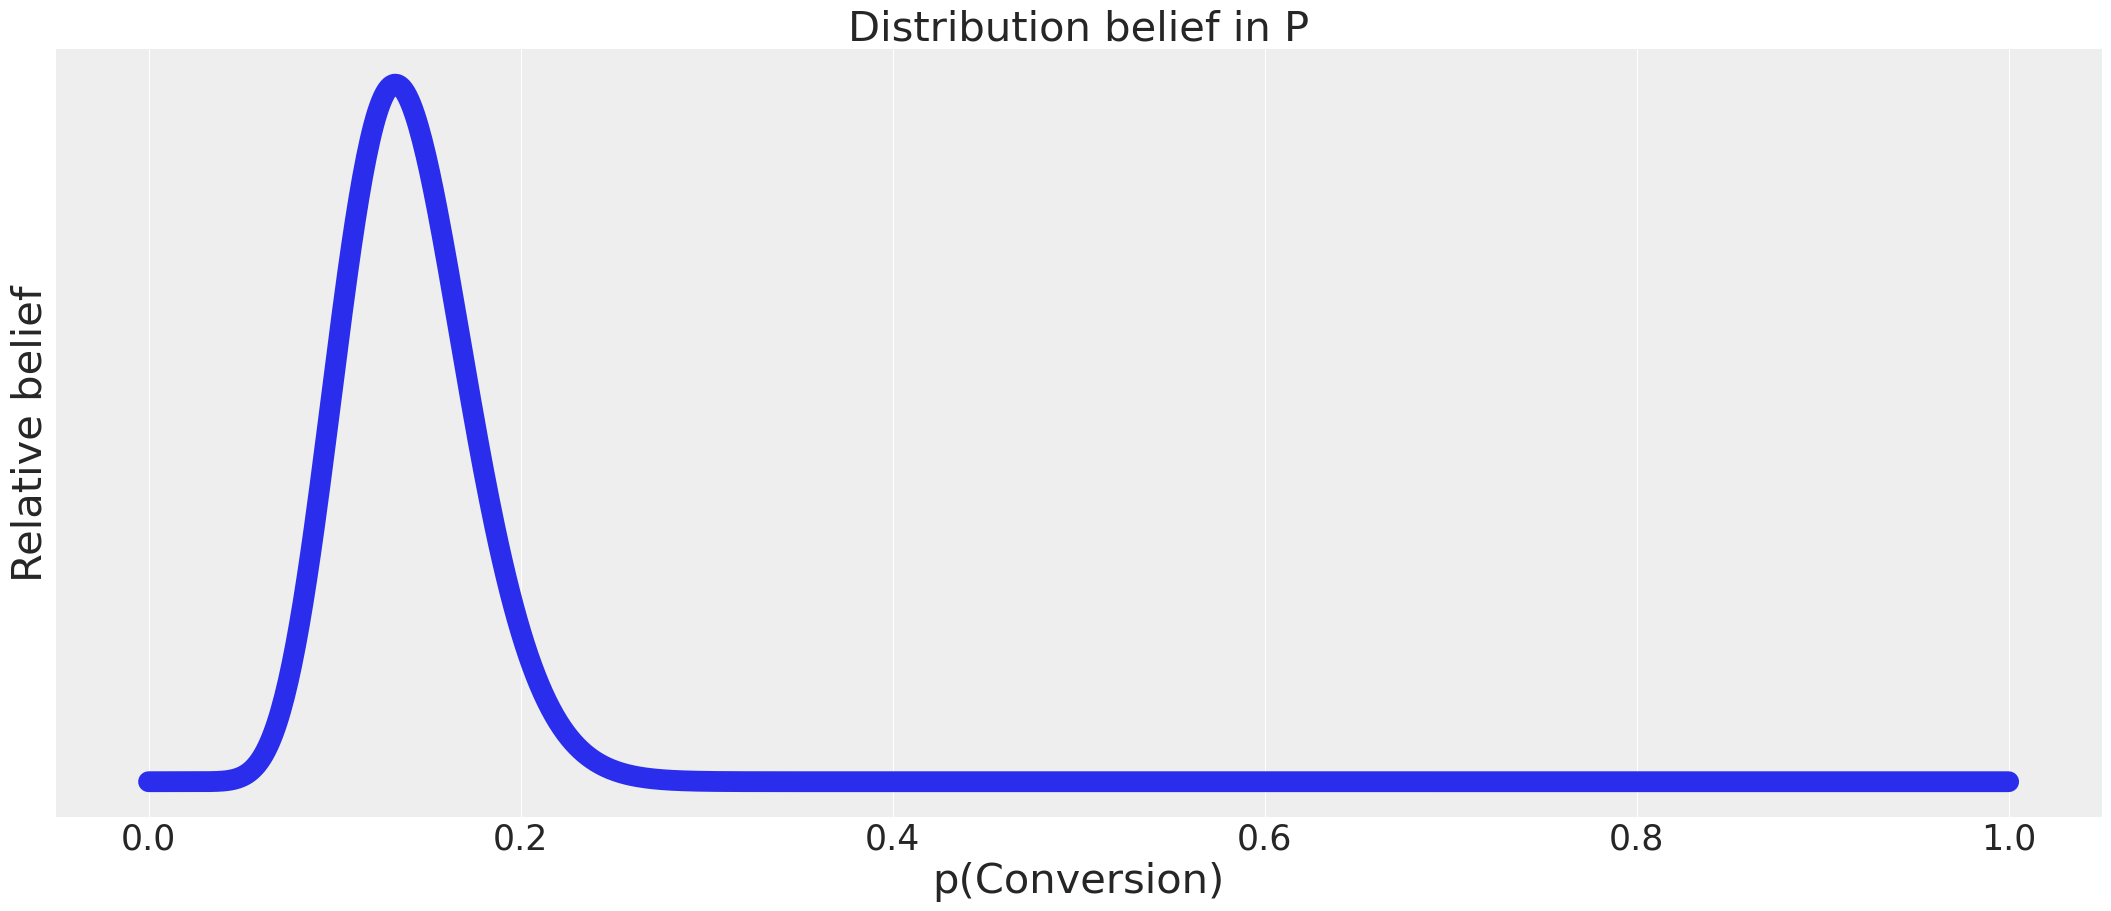

In [12]:
beta_dist = stats.beta(14, 86)
x = np.linspace(0, 1, 1000)
y = beta_dist.pdf(x)
fig, ax = plt.subplots(figsize=(21,9))
ax.plot(x,y, linewidth=15)

ax.set_yticks([])
ax.set_title("Distribution belief in P", fontsize=30)
ax.set_xlabel("p(Conversion)", fontsize=30)
ax.set_ylabel("Relative belief", fontsize=30)
ax.tick_params(axis='x', labelsize=25)

Given our results from the full `b_observations` array our beliefs of `p(conversion)` may look like the distribution below. 

We're *pretty sure* 10% is the most likely p conversion value, but 5% and 20% might be plausible as well. 0% and 100% are definitely out though.



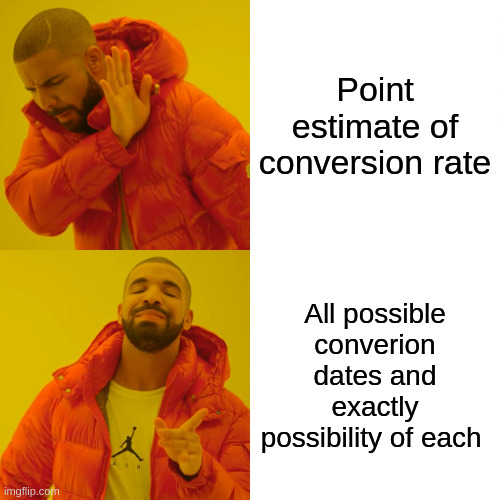

We don't just believe *one* value we believe *every* value and can precisely describe by how much.

This distributional belief system is a key differentiator of Bayesian approaches versus most other machine learning methods. 

## Section Recap
* Distributions can describe many things, such as probability, observations, and parameters
    * The values of things we can directly observe
    * Our beliefs in the parameters that we can't directly observe
* Probabilities are a *special case* of distributions
* Distributions let us express not one belief in the world, but all our beliefs and the relative belief in each

# Skipped slides

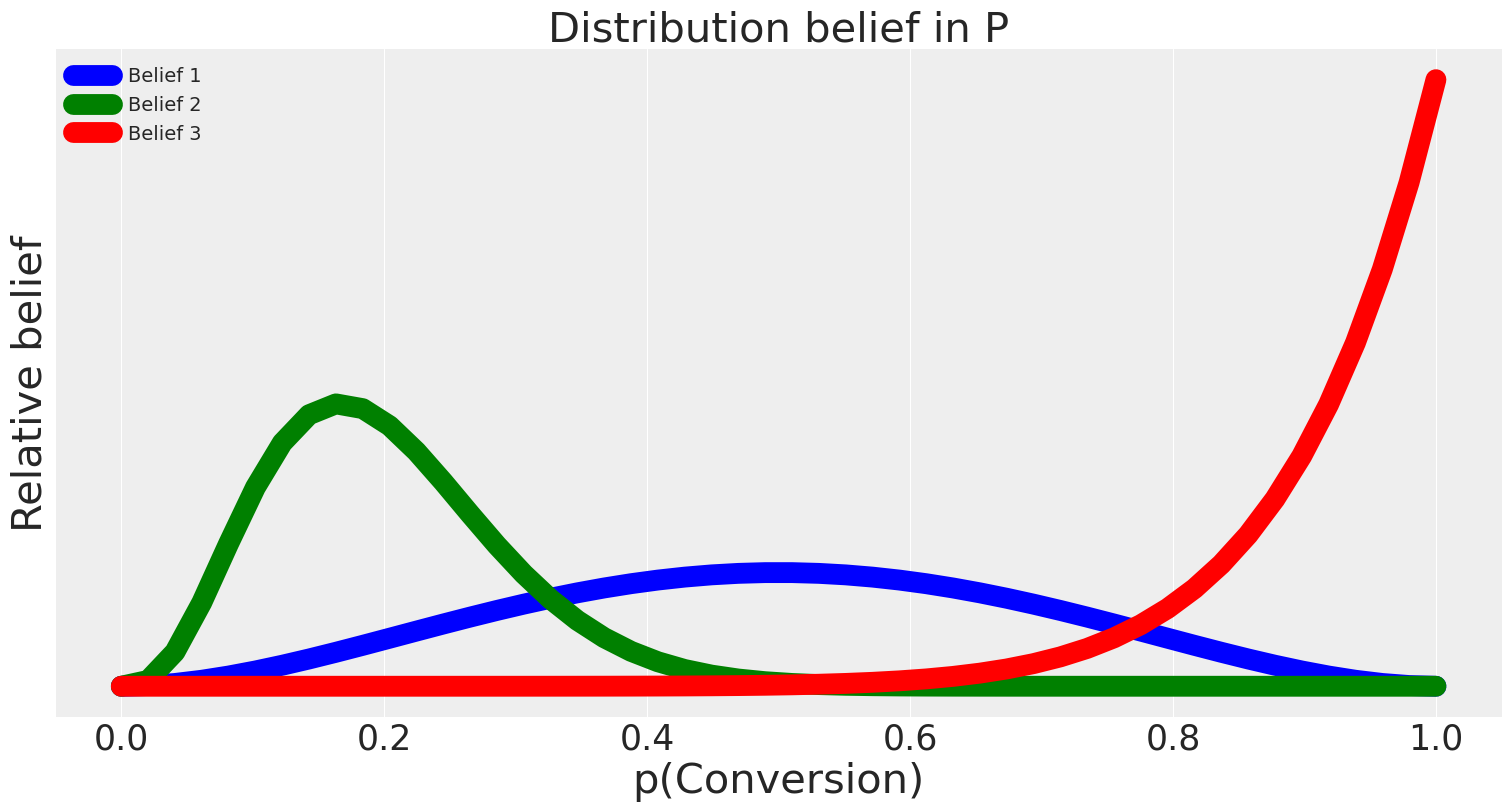

In [13]:
# Skipped 
fig, ax = plt.subplots(figsize=(15,8))

for i, (a, b, c) in enumerate(((3,3,'blue'), (4,16,'green'), (10,1,'red'))):

    beta_dist = stats.beta(a, b)
    x = np.linspace(0, 1)
    y = beta_dist.pdf(x)
    ax.plot(x,y, linewidth=15, c=c, label=f"Belief {i+1}")

    ax.set_yticks([])
    ax.set_title("Distribution belief in P", fontsize=30)
    ax.set_xlabel("p(Conversion)", fontsize=30)
    ax.set_ylabel("Relative belief", fontsize=30)
    ax.tick_params(axis='x', labelsize=25)

ax.legend()